In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.path
%aimport utils.backtest
%aimport utils.backtest_result
%aimport solvers
%aimport solvers.DRconditionalmeanvariance

In [2]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys
import factors

In [4]:
exp_num = 50
seed = 42
DRCME_inf_params = {
    'model_name': ['DRCMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRconditionalmeanvariance.DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel], 
    'start_index':['2012'],
    'end_index':['2014'],
    'reg_params':[2.0], 
    'gamma_quantile':[0.1, 0.25, 0.5], 
    'rho_quantile':[0.05, 0.1, 0.25], 
}
DRCME_2_params = {
    'model_name': ['OTCMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRconditionalmeanvariance.DR_W2_conditional_mean_variance_long_only_opt_cvx_kernel_new], 
    'start_index':['2012'],
    'end_index':['2014'],
    'reg_params':[2.0], 
    'epsilon':[0.2], 
    'rho_div_rho_min':[1.2]
}
equal_weight_params = {
    'model_name': ['EW'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.simple.equal_weight], 
    'start_index':['2012'],
    'end_index':['2014'],
}
DR_params = {
    'model_name': ['DRMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRmeanvariance.DR_mean_variance_long_only_opt_mosek_kernel_p2], 
    'reg_params':[2.0],
    'delta': [0.1,0.2,0.5],
    'p': [2.0],
    'start_index':['2012'],
    'end_index':['2014'],
}
mean_variance_params = {
    'model_name': ['MV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel], 
    'solver_name_prefix': ['vanilla_'],
    'reg_params':[2.0], 
    'start_index':['2012'],
    'end_index':['2014'],
}
conditional_mean_variance_params = {
    'model_name': ['CMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel], 
    'solver_name_prefix': ['fama_french_'],
    'reg_params':[2.0], 
    'start_index':['2012'],
    'end_index':['2014'],
}

In [5]:
plt.rc('axes', facecolor='#dedede', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#dedede')
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
utils.backtest_result_sherlock.plot_backtest_cross_validation_result(256, 0, [equal_weight_params,
                                                                            mean_variance_params,
                                                                            DR_params,
                                                                            conditional_mean_variance_params,
                                                                            DRCME_inf_params,
                                                                            DRCME_2_params])

KeyboardInterrupt: 

In [6]:
from utils.backtest_result_sherlock import read_single_solver_backtest_cross_validation_result
CV_params_dict_list = [equal_weight_params,
                     mean_variance_params,
                     DR_params,
                     conditional_mean_variance_params,
                     DRCME_inf_params,
                     DRCME_2_params]
exp_num = 256; seed = 0;
PnL_table_list = [read_single_solver_backtest_cross_validation_result(exp_num, seed, CV_params_dict)
                      for CV_params_dict in CV_params_dict_list]
legend_str_list = [CV_params_dict['model_name'][0] for CV_params_dict in CV_params_dict_list]

In [7]:
SR_table = pd.DataFrame({legend_str_list[i]:np.sqrt(252) * PnL_table_list[i].mean() 
                         / PnL_table_list[i].std() for i in range(6)})

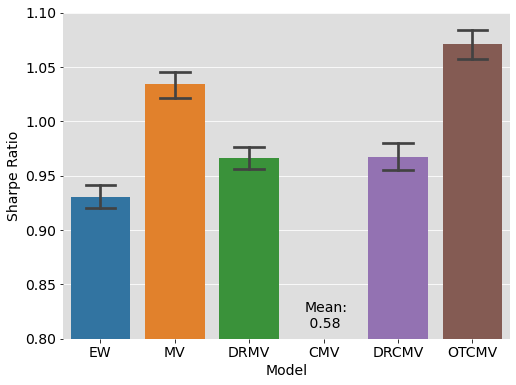

In [8]:
import seaborn as sns
sns.barplot(data=SR_table, ci = 68, capsize = 0.4)
plt.ylim([0.8,1.1])
plt.ylabel('Sharpe Ratio')
plt.xlabel('Model')
plt.text(3-0.25,0.81,'Mean:\n {:.2f}'.format(SR_table.iloc[:,3].mean()))
plt.savefig('figures/US_sharpe_bar_plot.pdf')

In [9]:
from scipy import stats
for i in range(5):
    print(stats.ttest_ind(SR_table.iloc[:,i],SR_table.iloc[:,-1], equal_var = False))

Ttest_indResult(statistic=-8.551471204079636, pvalue=1.5999804119010063e-16)
Ttest_indResult(statistic=-2.093809976467658, pvalue=0.036772187716182604)
Ttest_indResult(statistic=-6.362268849353243, pvalue=4.6026769861267475e-10)
Ttest_indResult(statistic=-24.083229862719605, pvalue=4.8352130297316537e-85)
Ttest_indResult(statistic=-5.615813065163993, pvalue=3.220069441850148e-08)


In [10]:
quantile_table = pd.DataFrame({legend_str_list[i]:PnL_table_list[i].quantile(0.05) for i in range(6)})

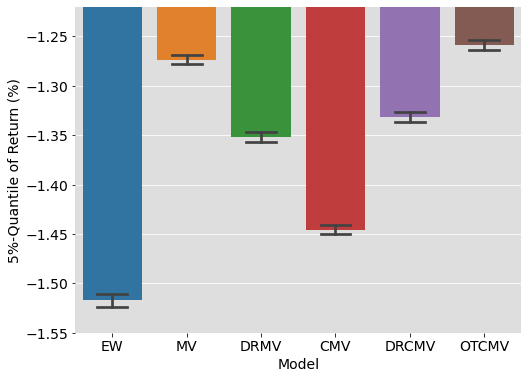

In [13]:
sns.barplot(data=quantile_table, ci = 68, capsize = 0.4)
plt.ylim([-1.55,-1.22])
plt.ylabel('5%-Quantile of Return (%)')
plt.xlabel('Model')
plt.savefig('figures/US_return_quantile_bar_plot.pdf')
#plt.ylim([-2.2,-1.7])